# Engenharia de Atributos

In [1]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [2]:
import pandas as pd

nome_arquivo = f'2.atributos.parquet'
df = pd.read_parquet(nome_arquivo)

2025-06-09 11:44:09 - INFO - NumExpr defaulting to 8 threads.


# Filtra município

In [3]:
df = df[df.municipio == 'Conselheiro Lafaiete']
len(df)

1849

## Verifica NaNs

In [4]:
df.isna().sum()

regiao                    0
estado                    0
municipio                 0
coduf                     0
codmun                    0
cod_regiao_saude          0
nome_regiao_saude         0
data                      0
semana_epi                0
populacao_tcu_2019        0
casos_acumulados          0
casos_novos               0
obitos_acumulados         0
obitos_novos              0
interior_metropolitana    0
novos_casos_novos         0
novos_casos_acumulados    0
mes                       0
mes_traduzido             0
dia_semana                0
dia_semana_traduzido      0
estacao                   0
dtype: int64

## Verifica Infs

In [5]:
num_cols = ['coduf', 'codmun', 'cod_regiao_saude', 'semana_epi', 'populacao_tcu_2019',
'casos_acumulados', 'casos_novos', 'obitos_acumulados', 'obitos_novos',
'interior_metropolitana', 'novos_casos_novos', 'novos_casos_acumulados']
df[num_cols]

,coduf,codmun,cod_regiao_saude,semana_epi,populacao_tcu_2019,casos_acumulados,casos_novos,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,novos_casos_acumulados
2438831,31,311830.0,31079.0,13,128589.0,0.0,0,0,0,0.0,0,0
2438832,31,311830.0,31079.0,13,128589.0,0.0,0,0,0,0.0,0,0
2438833,31,311830.0,31079.0,14,128589.0,0.0,0,0,0,0.0,0,0
2438834,31,311830.0,31079.0,14,128589.0,0.0,0,0,0,0.0,0,0
2438835,31,311830.0,31079.0,14,128589.0,0.0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2440675,31,311830.0,31079.0,16,128589.0,27454.0,0,345,0,0.0,0,27454
2440676,31,311830.0,31079.0,16,128589.0,27454.0,0,345,0,0.0,0,27454
2440677,31,311830.0,31079.0,16,128589.0,27454.0,0,345,0,0.0,0,27454
2440678,31,311830.0,31079.0,16,128589.0,27454.0,0,345,0,0.0,0,27454


In [6]:
import numpy as np

np.isinf(df[num_cols]).sum()

coduf                     0
codmun                    0
cod_regiao_saude          0
semana_epi                0
populacao_tcu_2019        0
casos_acumulados          0
casos_novos               0
obitos_acumulados         0
obitos_novos              0
interior_metropolitana    0
novos_casos_novos         0
novos_casos_acumulados    0
dtype: int64

## Verifica Negativos

In [7]:
df[(df.novos_casos_novos < 0) | (df.obitos_novos < 0)]

,regiao,estado,municipio,coduf,codmun,cod_regiao_saude,nome_regiao_saude,data,semana_epi,populacao_tcu_2019,...,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,novos_casos_acumulados,mes,mes_traduzido,dia_semana,dia_semana_traduzido,estacao
2438902,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2020-06-06,23,128589.0,...,0,-337,0.0,-27229,42,June,Junho,Saturday,Sábado,Outono
2438920,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2020-06-24,26,128589.0,...,1,0,0.0,-1,83,June,Junho,Wednesday,Quarta-feira,Inverno
2438944,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2020-07-18,29,128589.0,...,1,-1,0.0,9,224,July,Julho,Saturday,Sábado,Inverno
2439076,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2020-11-27,48,128589.0,...,20,-1,0.0,23,1586,November,Novembro,Friday,Sexta-feira,Primavera
2439712,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2022-08-25,34,128589.0,...,318,-1,0.0,0,25148,August,Agosto,Thursday,Quinta-feira,Inverno
2439871,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2023-01-31,5,128589.0,...,330,-1,0.0,158,27374,January,Janeiro,Tuesday,Terça-feira,Verão
2439894,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2023-02-23,8,128589.0,...,330,-1,0.0,0,27407,February,Fevereiro,Thursday,Quinta-feira,Verão
2439924,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2023-03-25,12,128589.0,...,331,0,0.0,-48,27411,March,Março,Saturday,Sábado,Outono
2440099,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2023-09-16,37,128589.0,...,332,1,0.0,-435,27012,September,Setembro,Saturday,Sábado,Inverno
2440407,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2024-07-20,29,128589.0,...,337,0,0.0,-4,27268,July,Julho,Saturday,Sábado,Inverno


In [8]:
df = df[(df.novos_casos_novos >= 0) & (df.obitos_novos >= 0)]
len(df)

1836

In [9]:
# print(len(df))
# display(df[(df.novos_casos_novos == -27270) | (df.novos_casos_novos == -27229) | (df.novos_casos_novos == 27270) | (df.novos_casos_novos == 27232)])
# df = df[(df.novos_casos_novos != 27232) & (df.novos_casos_novos != 27270) & (df.novos_casos_novos >= 0)]
# print(len(df))

# Engenharia de atributos

In [10]:
def remove_nans_and_infs(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    df.fillna(0, inplace=True)
    return df

In [11]:
from sklearn.preprocessing import LabelEncoder

def encode(df):
    le = LabelEncoder()

    cols_to_encode = ['regiao', 'estado', 'municipio', 'estacao']

    for col in cols_to_encode:
        df[col] = le.fit_transform(df[col])
    
    return df

In [12]:
def _adicionar_lag_features(df):
    df["novos_casos_novos_lag_1"] = df['novos_casos_novos'].shift(1)
    df["obitos_novos_lag_1"] = df['obitos_novos'].shift(1)

    df["novos_casos_novos_lag_7"] = df['novos_casos_novos'].shift(7)
    df["obitos_novos_lag_7"] = df['obitos_novos'].shift(7)

    df["novos_casos_novos_lag_14"] = df['novos_casos_novos'].shift(14)
    df["obitos_novos_lag_14"] = df['obitos_novos'].shift(14)

    return df

def _adicionar_media_movel_7(df):
    df['novos_casos_novos_media_movel_7'] = df['novos_casos_novos'].transform(lambda x: x.shift(1).rolling(7).mean())
    df['obitos_novos_media_movel_7'] = df['obitos_novos'].transform(lambda x: x.shift(1).rolling(7).mean())

    return df

In [13]:
def _rodar_engenharia_de_atributos(df):
    # df = _adicionar_lag_features(df)
    df = _adicionar_media_movel_7(df)
    df = remove_nans_and_infs(df)
    df = encode(df)
    
    return df

In [14]:
from tqdm import tqdm

def _processar(df):
    logging.info("Processando municipios_unicos")
    municipios_unicos = set(zip(df['municipio'], df['estado']))
    logging.info("Processamento concluído")

    logging.info("Filtrando o dataframe ")
    mascara = df.apply(lambda x: (
        x['municipio'], x['estado']) in municipios_unicos, axis=1)
    filtrado_df = df[mascara]
    logging.info("Processamento concluído")

    logging.info("Processando grupos")
    agrupado = filtrado_df.groupby(['municipio', 'estado'])
    logging.info("Processamento concluído")

    resultado_df = []

    for (municipio, estado), group_df in tqdm(agrupado, desc="Processando"):
        try:
            group_df = group_df.sort_values(by='data')
            resultado_df.append(_rodar_engenharia_de_atributos(group_df))
        except Exception as e:
            logging.error(f"{estado}_{municipio} não foi salvo")
            logging.error(e)

    resultado_df = pd.concat(resultado_df)
    return resultado_df

In [15]:
df = _processar(df)

2025-06-09 11:44:28 - INFO - Processando municipios_unicos
2025-06-09 11:44:28 - INFO - Processamento concluído
2025-06-09 11:44:28 - INFO - Filtrando o dataframe 
2025-06-09 11:44:28 - INFO - Processamento concluído
2025-06-09 11:44:28 - INFO - Processando grupos
2025-06-09 11:44:28 - INFO - Processamento concluído
Processando: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]


# Correlação e remoção de colunas

In [16]:
cols_to_drop = ['mes', 'mes_traduzido', 'dia_semana', 'dia_semana_traduzido', 'casos_novos', 'casos_acumulados', 
                'coduf', 'codmun', 'cod_regiao_saude', 'nome_regiao_saude']
df = df.drop(columns=cols_to_drop)

<Axes: >

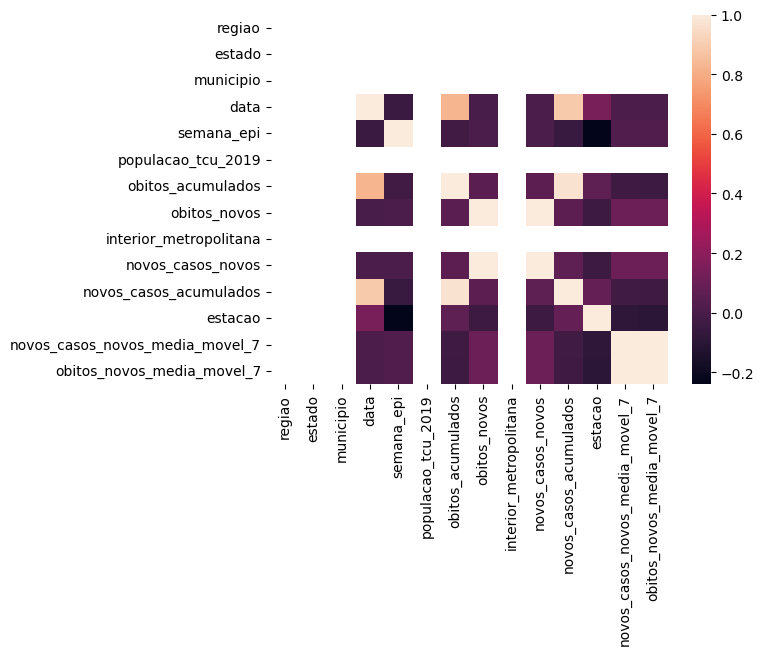

In [17]:
from seaborn import heatmap

heatmap(df.corr())

In [18]:
df

,regiao,estado,municipio,data,semana_epi,populacao_tcu_2019,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,novos_casos_acumulados,estacao,novos_casos_novos_media_movel_7,obitos_novos_media_movel_7
2438831,0,0,0,2020-03-27,13,128589.0,0,0,0.0,0,0,1,0.0,0.0
2438832,0,0,0,2020-03-28,13,128589.0,0,0,0.0,0,0,1,0.0,0.0
2438833,0,0,0,2020-03-29,14,128589.0,0,0,0.0,0,0,1,0.0,0.0
2438834,0,0,0,2020-03-30,14,128589.0,0,0,0.0,0,0,1,0.0,0.0
2438835,0,0,0,2020-03-31,14,128589.0,0,0,0.0,0,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440675,0,0,0,2025-04-14,16,128589.0,345,0,0.0,0,27454,1,0.0,0.0
2440676,0,0,0,2025-04-15,16,128589.0,345,0,0.0,0,27454,1,0.0,0.0
2440677,0,0,0,2025-04-16,16,128589.0,345,0,0.0,0,27454,1,0.0,0.0
2440678,0,0,0,2025-04-17,16,128589.0,345,0,0.0,0,27454,1,0.0,0.0


In [19]:
df.columns

Index(['regiao', 'estado', 'municipio', 'data', 'semana_epi',
       'populacao_tcu_2019', 'obitos_acumulados', 'obitos_novos',
       'interior_metropolitana', 'novos_casos_novos', 'novos_casos_acumulados',
       'estacao', 'novos_casos_novos_media_movel_7',
       'obitos_novos_media_movel_7'],
      dtype='object')

# XGBoost

In [20]:
from xgboost import XGBRegressor

def treinamento(df_treino, df_teste):
  X_treino, y_treino = df_treino[df_treino.columns.difference(['novos_casos_novos', 'data'])], df_treino[['novos_casos_novos']]
  X_teste = df_teste[df_teste.columns.difference(['novos_casos_novos', 'data'])]

  model = XGBRegressor()
  model.fit(X_treino, y_treino)

  coluna_predita = model.predict(X_teste)

  df_teste['predicao'] = coluna_predita

  return df_teste, model.feature_importances_


In [21]:
df_teste, feature_importances = treinamento(df.iloc[:-1], pd.DataFrame([df.iloc[-1]]))

df_teste.head(5)

,regiao,estado,municipio,data,semana_epi,populacao_tcu_2019,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,novos_casos_acumulados,estacao,novos_casos_novos_media_movel_7,obitos_novos_media_movel_7,predicao
2440679,0,0,0,2025-04-18,16,128589.0,345,0,0.0,0,27454,1,0.0,0.0,0.137337


# Darts

In [22]:
lags_future_covariates = ['regiao', 'estado', 'municipio', 'semana_epi', 'populacao_tcu_2019', 'interior_metropolitana', 'estacao']
lags_past_covariates = ['obitos_acumulados', 'obitos_novos', 'novos_casos_novos_media_movel_7', 'obitos_novos_media_movel_7']
target = ['novos_casos_novos']
temporal_var = ['data']

## Verificando se existe alguma covariável negativa

In [23]:
print((df[lags_past_covariates] < 0).sum())
print((df[lags_future_covariates] < 0).sum())

obitos_acumulados                  0
obitos_novos                       0
novos_casos_novos_media_movel_7    0
obitos_novos_media_movel_7         0
dtype: int64
regiao                    0
estado                    0
municipio                 0
semana_epi                0
populacao_tcu_2019        0
interior_metropolitana    0
estacao                   0
dtype: int64


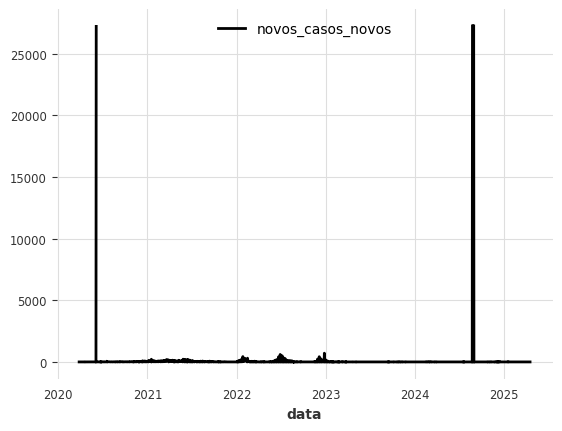

In [24]:
from darts import TimeSeries
import matplotlib.pyplot as plt

future_covariates = TimeSeries.from_dataframe(df[temporal_var + lags_future_covariates], time_col="data", freq="D", 
                                              fill_missing_dates=True)
past_covariates = TimeSeries.from_dataframe(df[temporal_var + lags_past_covariates], time_col="data", freq="D", 
                                            fill_missing_dates=True)
series = TimeSeries.from_dataframe(df[temporal_var + target], time_col="data", freq="D", fill_missing_dates=True)
_ = series.plot()

# Particiona série em treino e validação

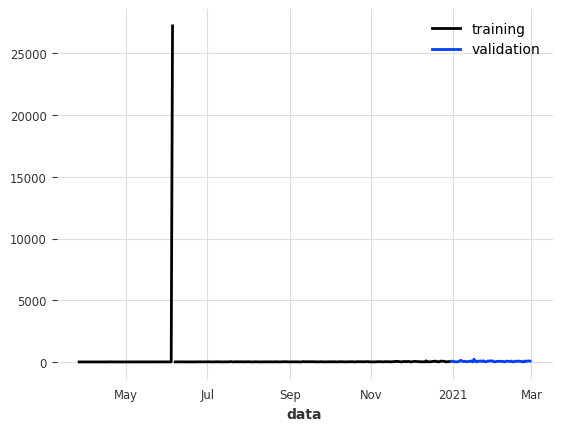

In [25]:
train, slice2 = series.split_before(pd.Timestamp("20201231"))
val, res = slice2.split_before(pd.Timestamp("20210301"))
_ = train.plot(label="training")
_ = val.plot(label="validation")

# Modelo Baseline 

#### (tendência + sazonalidade)

Encontrando o melhor k para o modelo baseline

In [26]:
from darts.models import NaiveDrift, NaiveSeasonal
from darts.metrics import mae

errors = {}
for i in range(1, 90):
    model1 = NaiveSeasonal(K=i)
    model1.fit(train)
    seasonal_forecast = model1.predict(len(val))

    model2 = NaiveDrift()
    model2.fit(train)
    drift_forecast = model2.predict(len(val))

    combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
    errors[i] = mae(val, combined_forecast)

sorted_by_values = dict(sorted(errors.items(), key=lambda item: item[1]))
sorted_by_values

/home/daniela.gomes/anaconda3/envs/covid/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/daniela.gomes/anaconda3/envs/covid/lib/python3.13/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
2025-06-09 11:44:54 - WARNING - The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.


{14: np.float64(25.191127098321342),
 42: np.float64(26.53398660382039),
 2: np.float64(27.439448441247002),
 7: np.float64(27.453956834532374),
 1: np.float64(27.57757793764988),
 49: np.float64(27.607608828191683),
 41: np.float64(28.627263706276356),
 6: np.float64(28.883333333333333),
 50: np.float64(28.9530545055481),
 36: np.float64(29.153932026792358),
 56: np.float64(29.40238995244482),
 63: np.float64(29.629191562004632),
 35: np.float64(29.7356735301414),
 77: np.float64(30.129618339226923),
 64: np.float64(30.268991586391902),
 28: np.float64(30.38872901678657),
 5: np.float64(30.608033573141483),
 3: np.float64(30.78429256594724),
 8: np.float64(30.791726618705034),
 62: np.float64(31.121570540178027),
 70: np.float64(31.16327277161322),
 43: np.float64(31.167824361200694),
 18: np.float64(31.42434052757794),
 84: np.float64(31.61541275454213),
 69: np.float64(31.641019387879528),
 71: np.float64(31.772710645043286),
 12: np.float64(31.94112709832134),
 16: np.float64(32.16

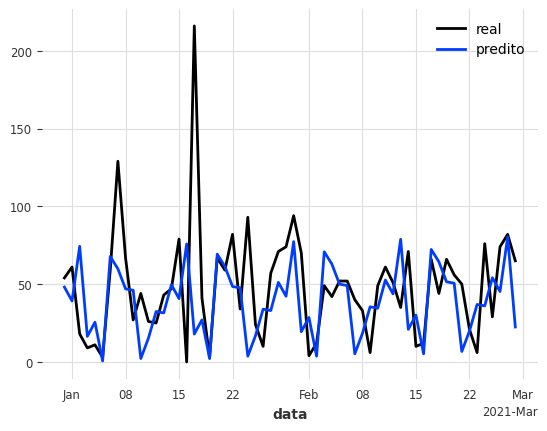

model NaiveSeasonal(K=14) obtains MAE: 27.58%
model NaiveDrift() obtains MAE: 26.27%
model NaiveDrift() obtains MAE: 25.19%


In [27]:
model1 = NaiveSeasonal(K=14)
model1.fit(train)
seasonal_forecast = model1.predict(len(val))

model2 = NaiveDrift()
model2.fit(train)
drift_forecast = model2.predict(len(val))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
errors[i] = mae(val, combined_forecast)

val.plot(label='real')
combined_forecast.plot(label='predito')
plt.show()
plt.close()
print(f"model {model1} obtains MAE: {mae(val, drift_forecast):.2f}%")
print(f"model {model2} obtains MAE: {mae(val, seasonal_forecast):.2f}%")
print(f"model {model2} obtains MAE: {mae(val, combined_forecast):.2f}%")

# Limpando séries

In [28]:
from darts import TimeSeries
import numpy as np

def clean_timeseries(ts: TimeSeries):
    df = ts.to_dataframe().copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)
    df.fillna(0, inplace=True)  # fallback final
    return TimeSeries.from_dataframe(df, time_col=None)


In [29]:
train = clean_timeseries(train)
past_covariates = clean_timeseries(past_covariates)
future_covariates = clean_timeseries(future_covariates)

/tmp/ipykernel_112732/240003353.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_112732/240003353.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
/tmp/ipykernel_112732/240003353.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_112732/240003353.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
/tmp/ipykernel_112732/240003353.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Us

In [30]:
import numpy as np

print("train:", train.to_dataframe().isna().sum())
print("past_covariates:", past_covariates.to_dataframe().isna().sum())
print("future_covariates:", future_covariates.to_dataframe().isna().sum())


train: component
novos_casos_novos    0
dtype: int64
past_covariates: component
obitos_acumulados                  0
obitos_novos                       0
novos_casos_novos_media_movel_7    0
obitos_novos_media_movel_7         0
dtype: int64
future_covariates: component
regiao                    0
estado                    0
municipio                 0
semana_epi                0
populacao_tcu_2019        0
interior_metropolitana    0
estacao                   0
dtype: int64


# Testando outros modelos

In [33]:
def eval_model(model, model_name, past, future, train, val):
    args = {}

    if past and model.supports_past_covariates:
        args["past_covariates"] = past_covariates
    if future and model.supports_future_covariates:
        args["future_covariates"] = future_covariates

    model.fit(series=train, **args)
    forecast = model.predict(n=len(val), **args)
    
    print(f"model {model} obtains MAE: {mae(val, forecast):.2f}")
    
    val.plot(label='real')
    forecast.plot(label='predito')
    plt.title(model_name)
    plt.show()
    plt.close()

    val_df = val.to_dataframe()
    forecast_df = forecast.to_dataframe()

    df = val_df.merge(forecast_df, on='data', suffixes=['_real', '_predito'])

    return df


model ExponentialSmoothing() obtains MAE: 63.79


/home/daniela.gomes/anaconda3/envs/covid/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


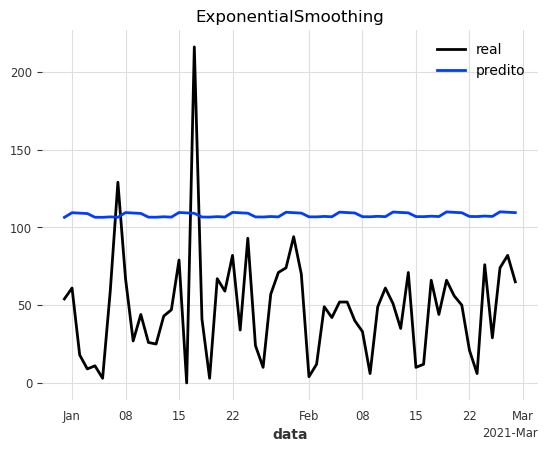

/home/daniela.gomes/anaconda3/envs/covid/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


model Theta() obtains MAE: 119.71


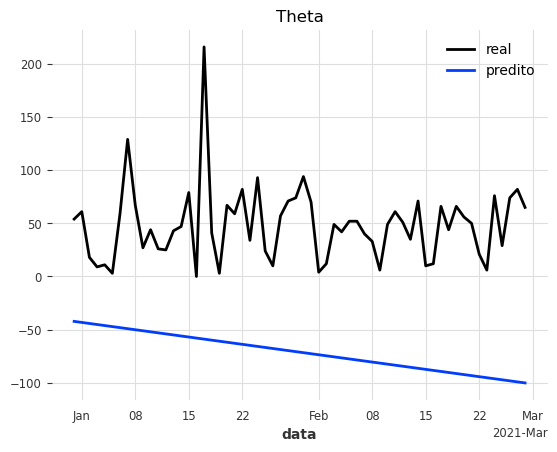

model ARIMA(p=15, q=7) obtains MAE: 111.94


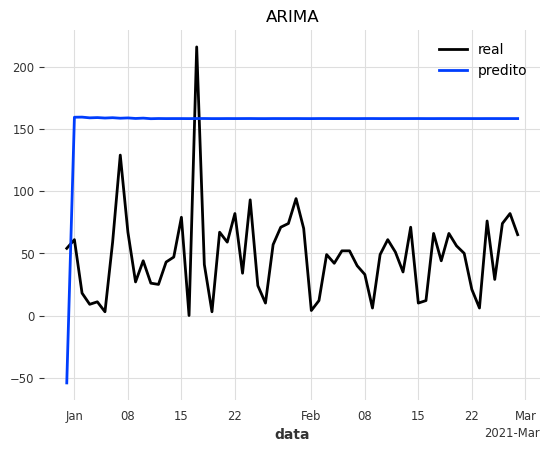

2025-06-09 11:54:07 - WARNING - `predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...) obtains MAE: 27.79


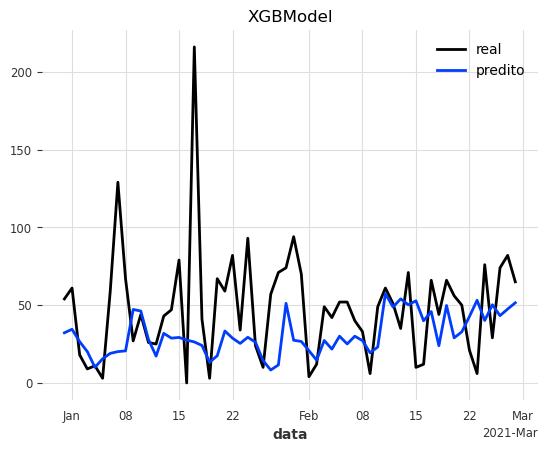

2025-06-09 11:54:07 - INFO - Train dataset contains 160 samples.
2025-06-09 11:54:07 - INFO - Time series values are 64-bits; casting model to float64.
2025-06-09 11:54:07 - INFO - GPU available: False, used: False
2025-06-09 11:54:07 - INFO - TPU available: False, using: 0 TPU cores
2025-06-09 11:54:07 - INFO - HPU available: False, using: 0 HPUs
2025-06-09 11:54:07 - INFO - 
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.7 M  | train
-------------------------------------------------------------
6.7 M     Trainable params
1.8 K     Non-trainable params
6.7 M     Total params
26.875    Total estimat

Epoch 42:   0%|          | 0/5 [00:00<?, ?it/s, train_loss=108.0]         

2025-06-09 11:58:01 - INFO - 
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [38]:
from darts.models import XGBModel, ExponentialSmoothing, ARIMA, Theta, NBEATSModel, TFTModel
from darts.utils.utils import ModelMode, SeasonalityMode

model_configs = [
    ("ExponentialSmoothing", False, False, 
     ExponentialSmoothing(trend=ModelMode.ADDITIVE)),

    ("Theta", False, False, Theta()),

    ("ARIMA", False, False, ARIMA(p=15, d=1, q=7)),

    ("XGBModel", True, True, 
     XGBModel(lags=7, lags_past_covariates=[-1, -7, -14, -30], lags_future_covariates=[1, 7, 14, 30], n_estimators=100)),

    ("NBEATSModel", False, False, 
     NBEATSModel(input_chunk_length=90, output_chunk_length=30, n_epochs=50))
]

df_results = pd.DataFrame()
for model in model_configs:
    df = eval_model(model[3], model[0], model[1], model[2], train, val)
    df['modelo'] = model[0]
    df_results = pd.concat([df_results, df])

In [37]:
df_results.to_csv("predicoes.csv", index=False)